# Analysis of IMU Orientation for Linus Vehicle

Goal: 
* Get the orientation of the IMU onboard, using flight data

Assumptions:
* Negligible rotation rates (p,q,r = 0)

In [1]:
from os import sys
import os
sys.path.append('../')

# Getting packages #
%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy.io

import plotly.express as px

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

import data_exporter

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
### Definining name of analysis ###
name = '2023-06-15_GettingIMUOffset'
data_path = '../data/'
data_folder = 'linus-2023-05-26'
file_name = '00000004.BIN'
datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

### Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "ArduPlane_4_3_3"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

In [3]:
# Setting Plot Defaults
plt.style.use('../basic_plotter.mplstyle')

In [4]:
# Vehicle parameters
prop = propellers.aeronaut11x7_estimatedBEN() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727 # Estimated with virtual bolt included
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

P_systems = 4 # Amount of power consumed by everything except the ESC & motor

highorderpolar = True

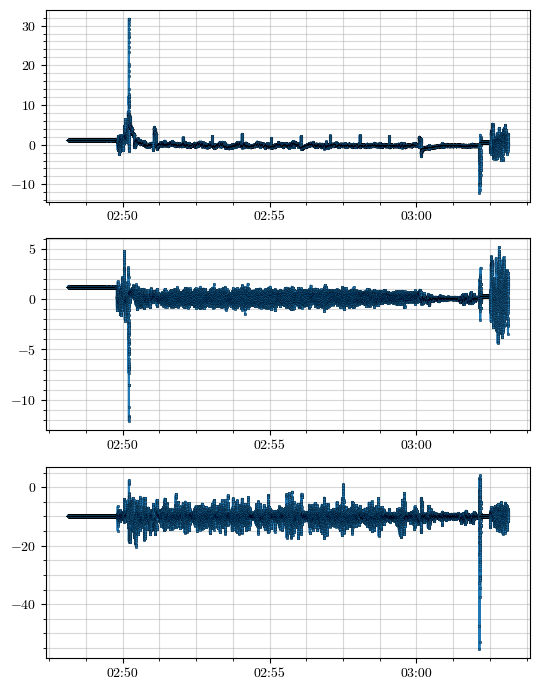

In [5]:
fig = plt.figure(figsize=(5.5,7))
ax0 = plt.subplot(3,1,1)
ax0.plot(df.index, df.XAcc_IMU0)

ax1 = plt.subplot(3,1,2, sharex=ax0)
ax1.plot(df.index, df.YAcc_IMU0)

ax2 = plt.subplot(3,1,3, sharex=ax0)
ax2.plot(df.index, df.ZAcc_IMU0)

plt.show()

In [6]:
### Mask Initialization ###

# Generating Start/End Times for Segments #
# Producing masks for dataframe

def get_mask(df, start, end, year, month, day):
    # Getting boolean mask from start and end times
    start_time = get_datetime(start, year, month, day)
    end_time = get_datetime(end, year, month, day)
    mask = (df.index > start_time) & (df.index < end_time)
    return mask

def get_datetime(hour_string, year, month, day):
    # Results completed datetime from hour string, and date
    split_nums = hour_string.split(':')
    hours = int(split_nums[0])
    minutes = int(split_nums[1])
    seconds = int(split_nums[2])
    return pd.Timestamp(year=year, month=month, day=day, hour=hours, minute=minutes, second=seconds)

year = 2023
month = 5
day = 27

# Cruise Masking
seg_times = np.array([['02:48:09', '02:49:47']])
# seg_times = np.array([['02:51:30','02:52:02'],
#                       ['02:52:04','02:53:02'],
#                       ['02:53:04','02:54:02'],
#                       ['02:54:04','02:55:03'],
#                       ['02:55:04','02:56:03'],
#                       ['02:56:04','02:57:03'],
#                       ['02:57:05','02:58:03'],
#                       ['02:58:05','02:59:03'],
#                       ['02:59:05','03:00:04']])
masks = []
for i in range(np.shape(seg_times)[0]):
    mask = get_mask(df, seg_times[i,0], seg_times[i,1], year, month, day)
    masks.append(mask)

In [22]:
############# Main Analysis ###############

# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians
theta = np.deg2rad(df["PitchAngle"].to_numpy())         # Pitch angle in radians

# Atmospheric adjustments:
rho = df["Pressure_BARO0"].to_numpy() * (287 * (df.Temperature_ARSP.to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude

# Inertial Measurement Unit
xp_acc = df.XAcc_IMU0.to_numpy()                       # Acceleration in X direction of the IMU
yp_acc = df.YAcc_IMU0.to_numpy()                       # Acceleration in Y direction of the IMU
zp_acc = df.ZAcc_IMU0.to_numpy()                       # Acceleration in Z direction of the IMU

U_dot = xp_acc - 9.807 * np.sin(theta)
V_dot = yp_acc + (9.807 * np.cos(theta) * np.sin(phi))
W_dot = zp_acc + (9.807 * np.cos(theta) * np.cos(phi))

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df.MainBatteryCurrent.to_numpy()
v_esc = df.MainBatteryVoltage.to_numpy()
#J = v_tas / (n * prop.diameter)

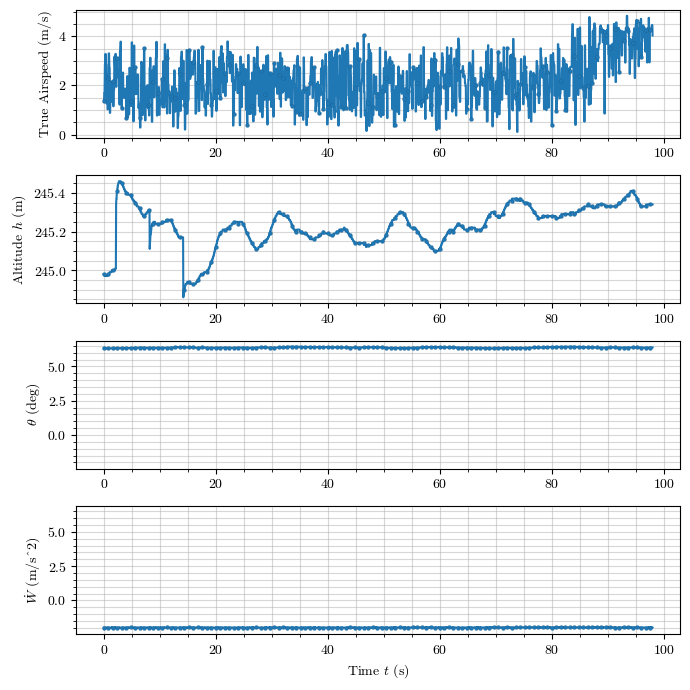

In [23]:
# Plotting Steady-level Data Runs #
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
plt.figure(figsize=(7,7))
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, h[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Altitude $h$ (m)")

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, np.rad2deg(theta[masks[i]]), marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("$\\theta$ (deg)")

ax3 = plt.subplot(4,1,4, sharex=ax1, sharey=ax2)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, W_dotp[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$\dot{W}$ (m/s^2)")
ax3.set_xlabel("Time $t$ (s)")

plt.show()
#plt.savefig("Figures/cruise_overview_pres.pdf", bbox_inches='tight')

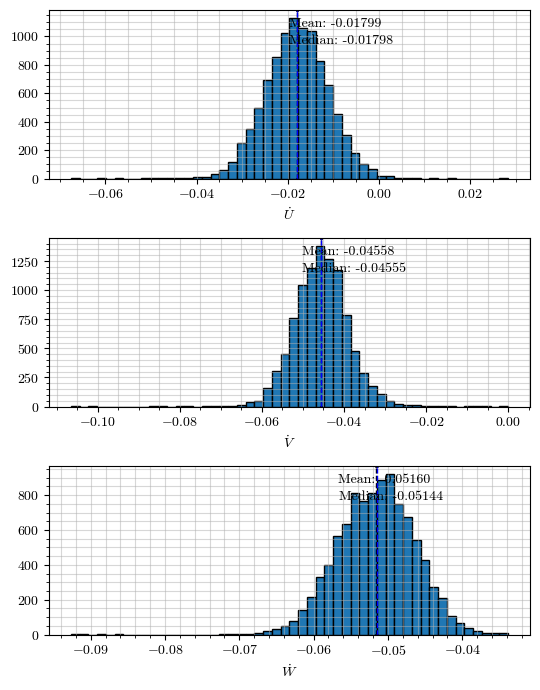

In [24]:
plt.figure(figsize=(5.5, 7))
plt.title("Body Accelerations in X Direction")

ax0 = plt.subplot(3,1,1)
ax0.hist(U_dot[masks[i]], bins=50, edgecolor='k')
ax0.axvline(np.mean(U_dot[masks[i]]), color='k', linestyle='dashed', linewidth=1)
ax0.axvline(np.median(U_dot[masks[i]]), color='b', linestyle='dashed', linewidth=1)
ax0.set_xlabel("$\dot{U}$")
min_ylim, max_ylim = ax0.set_ylim()
ax0.text(U_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(U_dot[masks[i]].mean()))
ax0.text(np.median(U_dot[masks[i]])*1.1, max_ylim*0.8, 'Median: {:.5f}'.format(np.median(U_dot[masks[i]])))

ax1 = plt.subplot(3,1,2)
ax1.hist(V_dot[masks[i]], bins=50, edgecolor='k')
ax1.axvline(np.mean(V_dot[masks[i]]), color='k', linestyle='dashed', linewidth=1)
ax1.axvline(np.median(V_dot[masks[i]]), color='b', linestyle='dashed', linewidth=1)
ax1.set_xlabel("$\dot{V}$")
min_ylim, max_ylim = ax1.set_ylim()
ax1.text(V_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(V_dot[masks[i]].mean()))
ax1.text(np.median(V_dot[masks[i]])*1.1, max_ylim*0.8, 'Median: {:.5f}'.format(np.median(V_dot[masks[i]])))

ax2 = plt.subplot(3,1,3)
ax2.hist(W_dot[masks[i]], bins=50, edgecolor='k')
ax2.axvline(np.mean(W_dot[masks[i]]), color='k', linestyle='dashed', linewidth=1)
ax2.axvline(np.median(W_dot[masks[i]]), color='b', linestyle='dashed', linewidth=1)
ax2.set_xlabel("$\dot{W}$")
min_ylim, max_ylim = ax2.set_ylim()
ax2.text(W_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(W_dot[masks[i]].mean()))
ax2.text(np.median(W_dot[masks[i]])*1.1, max_ylim*0.8, 'Median: {:.5f}'.format(np.median(W_dot[masks[i]])))

plt.show()

# for i in range(len(masks)):
#     ax = plt.subplot(3,3,i+1)
#     ax.hist(U_dot[masks[i]], bins=50, edgecolor='k')
#     ax.axvline(np.mean(U_dot[masks[i]]), color='k', linestyle='dashed', linewidth=1)
#     ax.axvline(np.median(U_dot[masks[i]]), color='b', linestyle='dashed', linewidth=1)
#     ax.set_xlabel("$\dot{U}$")
#     min_ylim, max_ylim = ax.set_ylim()
#     ax.text(U_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(U_dot[masks[i]].mean()))
#     ax.text(np.median(U_dot[masks[i]])*1.1, max_ylim*0.8, 'Median: {:.5f}'.format(np.median(U_dot[masks[i]])))

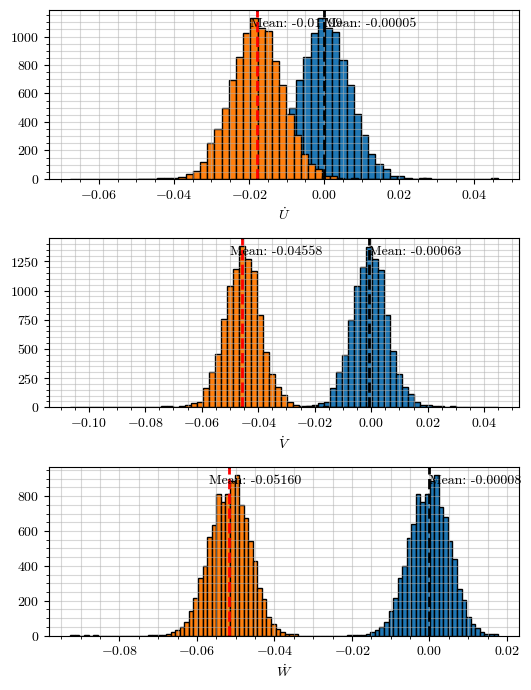

In [75]:
thetap = -0.133 * (np.pi/180)  # Pitch perturbation from IMU orientation (Degrees)
phip = 0.30 * (np.pi/180)  # Roll perturbation from IMU orientation (Degrees)
IMUtotal = np.sqrt(xp_acc**2 + yp_acc**2 + zp_acc**2)

U_dotp = xp_acc - (np.mean(IMUtotal[masks[0]]) * np.sin(theta+thetap))
V_dotp = yp_acc + (np.mean(IMUtotal[masks[0]]) * np.cos(theta+thetap) * np.sin(phi+phip))
W_dotp = zp_acc + (np.mean(IMUtotal[masks[0]]) * np.cos(theta+thetap) * np.cos(phi+phip))

def plot_hist():

    plt.figure(figsize=(5.5, 7))
    plt.title("Body Accelerations in X Direction")
    i = 0
    ax0 = plt.subplot(3,1,1)
    ax0.hist(U_dotp[masks[i]], bins=50, edgecolor='k', label='Adjusted')
    ax0.hist(U_dot[masks[i]], bins=50, edgecolor='k', label='Original')
    ax0.axvline(np.mean(U_dotp[masks[i]]), color='k', linestyle='dashed', linewidth=2)
    ax0.axvline(np.mean(U_dot[masks[i]]), color='r', linestyle='dashed', linewidth=2)
    ax0.set_xlabel("$\dot{U}$")
    min_ylim, max_ylim = ax0.set_ylim()
    ax0.text(U_dotp[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(U_dotp[masks[i]].mean()))
    ax0.text(U_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(U_dot[masks[i]].mean()))

    ax1 = plt.subplot(3,1,2)
    ax1.hist(V_dotp[masks[i]], bins=50, edgecolor='k', label='Adjusted')
    ax1.hist(V_dot[masks[i]], bins=50, edgecolor='k', label='Original')
    ax1.axvline(np.mean(V_dotp[masks[i]]), color='k', linestyle='dashed', linewidth=2)
    ax1.axvline(np.mean(V_dot[masks[i]]), color='r', linestyle='dashed', linewidth=2)
    ax1.set_xlabel("$\dot{V}$")
    min_ylim, max_ylim = ax1.set_ylim()
    ax1.text(V_dotp[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(V_dotp[masks[i]].mean()))
    ax1.text(V_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(V_dot[masks[i]].mean()))

    ax2 = plt.subplot(3,1,3)
    ax2.hist(W_dotp[masks[i]], bins=50, edgecolor='k', label='Adjusted')
    ax2.hist(W_dot[masks[i]], bins=50, edgecolor='k', label='Original')
    ax2.axvline(np.mean(W_dotp[masks[i]]), color='k', linestyle='dashed', linewidth=2)
    ax2.axvline(np.mean(W_dot[masks[i]]), color='r', linestyle='dashed', linewidth=2)
    ax2.set_xlabel("$\dot{W}$")
    min_ylim, max_ylim = ax2.set_ylim()
    ax2.text(W_dotp[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(W_dotp[masks[i]].mean()))
    ax2.text(W_dot[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(W_dot[masks[i]].mean()))

    plt.show()
plot_hist()


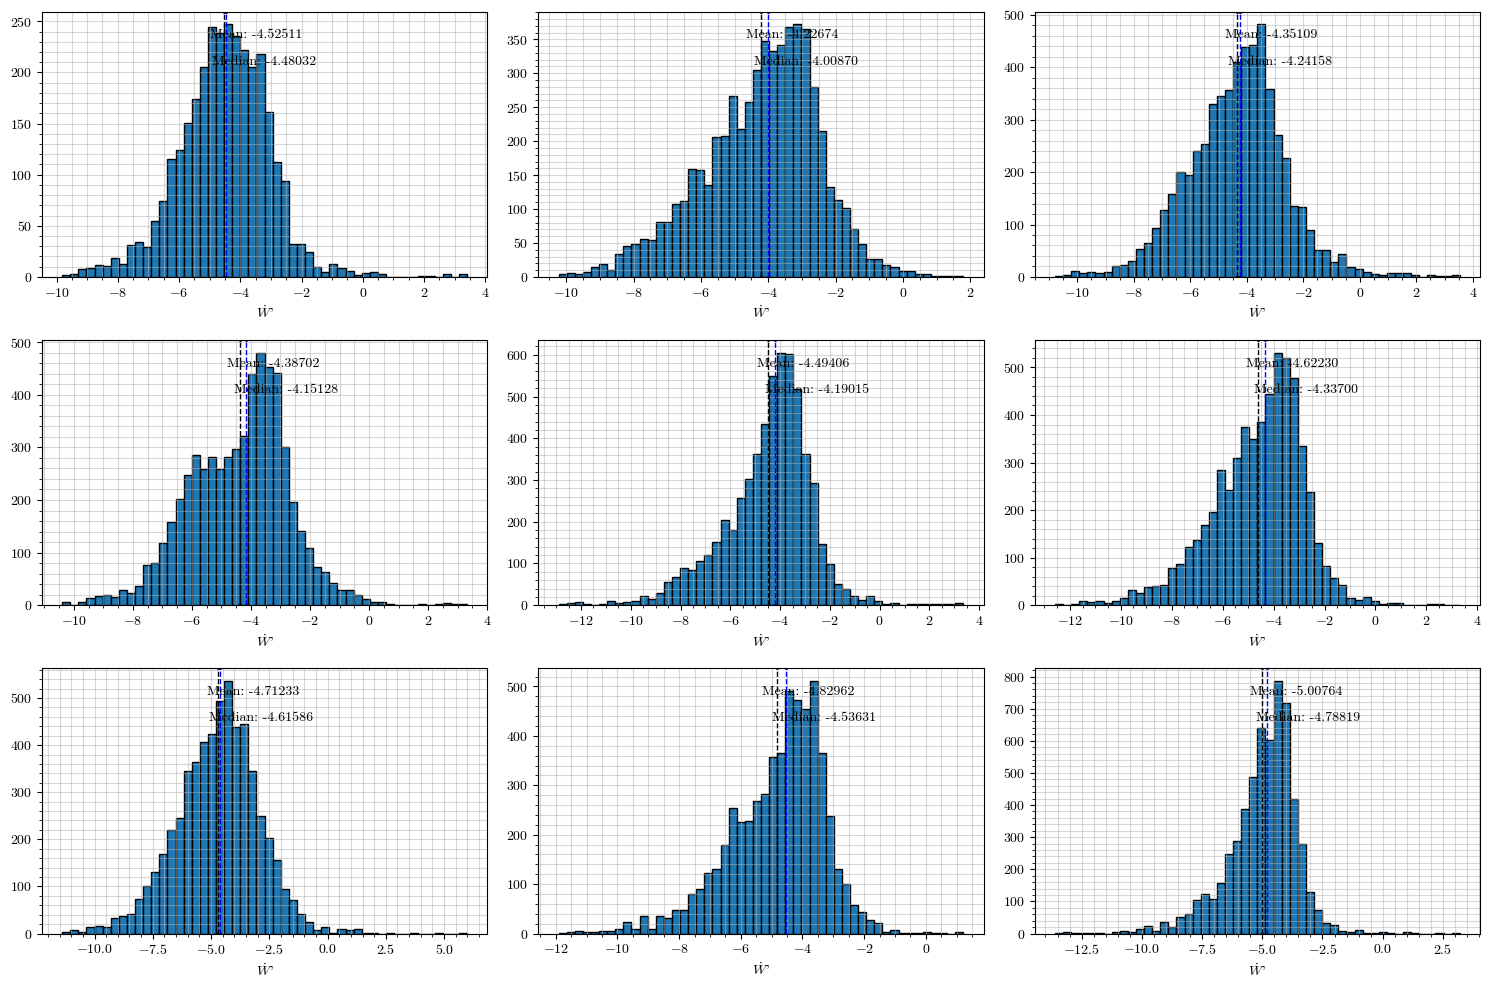

-4.572879248849805


In [75]:
plt.figure(figsize=(15,10))
plt.title("Body Accelerations in Z Direction")

means_ofmeans = np.zeros((9,1))
for i in range(len(masks)):
    ax0 = plt.subplot(3,3,i+1)
    ax0.hist(W_dotp[masks[i]], bins=50, edgecolor='k')
    ax0.axvline(np.mean(W_dotp[masks[i]]), color='k', linestyle='dashed', linewidth=1)
    ax0.axvline(np.median(W_dotp[masks[i]]), color='b', linestyle='dashed', linewidth=1)
    ax0.set_xlabel("$\dot{W}$'")
    min_ylim, max_ylim = ax0.set_ylim()
    ax0.text(W_dotp[masks[i]].mean()*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(W_dotp[masks[i]].mean()))
    ax0.text(np.median(W_dotp[masks[i]])*1.1, max_ylim*0.8, 'Median: {:.5f}'.format(np.median(W_dotp[masks[i]])))
    means_ofmeans[i,0] = np.mean(W_dotp[masks[i]])
plt.show()
print(means_ofmeans.mean())

## Some Conclusions:

From trying to obtain the IMU orientation to the aircraft body, using steady level flight from the June 15th data loiters:

1. The pitch offset is firmly determined at +0.585 degrees, so the IMU is inclined further than the aircraft body (From X acceleration data ONLY)
2. The roll offset is more difficult, with an offset of +4 degrees minimizing error in $\dot{W}$, but never able to completely force the $\dot{W}$ to zero, as it should be able to.  

Hypothesis, there are some $p$, $q$, $r$ magnitudes that are non-negligible, causing the issue.  For these tests, the yaw rate is clearly non-zero: (2 minute loiter, with yaw from 0 to $\pi$)

Estimated Yaw Rate: $P$

$ 2\pi / 120 s = 0.05235987756 rad/s$

Results in off acceleration measurement when the $V$ is not zero, so some velocity sideways in flight.  

$ a_z = \dot{W} - qU + PV - g cos(\theta) cos(\phi)$ 

To continue investigation with yawing rates estimated next time.  See if we can guess the position of the IMU relative to the CG!